In [1]:
import xarray as xr
import numpy as np
import rasterio as rio
import requests
import pandas as pd
import calendar
import rioxarray
import matplotlib.pyplot as plt
import glob

from pyproj import Proj, Transformer, CRS
from pathlib import Path
from wrf import PolarStereographic
from rasterio.warp import calculate_default_transform, reproject, Affine, Resampling, aligned_target
from rasterio.transform import array_bounds
from rasterio.plot import show

In [2]:
daymet_12km_vichydro_fp = Path("/atlas_scratch/cparr4/scratch/daymet")
daymet_met_files = list(daymet_12km_vichydro_fp.glob('*_met_*'))

In [3]:
def project_datacube(datacube):
    """
    Projects an xarray datacube to a polar stereographic grid with a 12 km resolution.
    
    Parameters
    ----------
    datacube : xarray.Dataset
        The input datacube to be projected. It should have the latitude and longitude dimensions.

    Returns
    -------
    projected_datacube : xarray.Dataset
        The projected datacube with the y and x dimensions. 
    wrf_raster_profile : dict
        A dictionary containing parameters for the output raster such as the transform and the
        dimensions of the raster. This will be used to write summarized slices of the projected datacube to a GeoTIFF file.
    """
    wrf_proj_str = PolarStereographic(**{"TRUELAT1": 64, "STAND_LON": -150}).proj4()
    wrf_proj = Proj(wrf_proj_str)
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    
    transformer = Transformer.from_proj(wgs_proj, wrf_proj)
    e, n = transformer.transform(-150, 64)
    # Grid parameters
    dx, dy = 12000, 12000
    
    try:
        ny, nx = datacube.longitude.shape[1:]
    except:
        ny, nx = datacube.longitude.shape # met case has a little different structure
    
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    x = np.arange(nx) * dx + x0
    y = np.arange(ny) * dy + y0
    
    projected_datacube = datacube.assign_coords({"y": ("y", y), "x": ("x", x)})
    
    # Output geotiff creation profile params  
    width = datacube.x.shape[0]
    height = datacube.y.shape[0]
    
    # west and north
    west = x0 - dx / 2
    north = y[-1] + dy / 2
    out_transform = rio.transform.from_origin(west, north, dx, dy)
    
    wrf_raster_profile = {
        "driver": "GTiff",
        "crs": CRS.from_proj4(wrf_proj_str),
        "transform": out_transform,
        "width": width,
        "height": height,
        "count": 1,
        "dtype": np.float32,
        "nodata": -9999,
        "tiled": False,
        "compress": "lzw",
        "interleave": "band",
    }
    
    datacube.close()
    
    return projected_datacube, wrf_raster_profile

def prep_ds(fp):
    with xr.open_dataset(fp) as ds:
        #assert (ds.isel(time=180)["tmin"].all() < ds.isel(time=180)["tmax"].all())
        ds["tavg"] = (ds["tmin"] + ds["tmax"]) / 2
        ds["tavg_F"] = ds["tavg"] * 9/5 + 32
        ds["tmin_F"] = ds["tmin"] * 9/5 + 32
        ds["tmax_F"] = ds["tmax"] * 9/5 + 32
        
        proj_ds, out_profile = project_datacube(ds)
    return proj_ds, out_profile

In [4]:
x, _ = prep_ds(daymet_met_files[0])
x

<xarray.Dataset>
Dimensions:    (y: 209, x: 299, time: 366)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-31T12:00:00
  * y          (y) float64 -4.04e+06 -4.028e+06 ... -1.556e+06 -1.544e+06
  * x          (x) float64 -1.788e+06 -1.776e+06 ... 1.776e+06 1.788e+06
Data variables:
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
    pcp        (time, y, x) float32 ...
    tmax       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tmin       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tavg       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tavg_F     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tmin_F     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tmax_F     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    start_year:                1980
    source:                    Daymet Software Version 3.0
    Version_software:          Daymet Software Version 3.0
    Version_data:              Daymet Data Version 3.0
    Conventions:               CF-1.0
    references:                Please see http://daymet.ornl.gov/ for current...
    title:                     WRF WPS
    history:                   Fri Mar 19 08:45:46 2021: ncatted -a citation,...
    NCO:                       netCDF Operators version 4.9.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [5]:
def summarize_year_dd(ds, t, below):
    
    if below:
        # Use a bool variable (below) to specify that the DD
        #  below the threshold should be counted. This
        #  will be the case for heating DD, DD below 0, and freezing index
        # adjustment for kelvin to celsius to farenheight
        dd_arr = t - ds.tavg_F
    else:
        # Otherwise, count degree days above some threshold t
        dd_arr = ds.tavg_F - t
    
    #year = ds.time.values[0].astype("datetime64[Y]").astype(int) + 1970
    
    # check if leap year - will have nan slice for 2/29 if so (index 59)
    # if calendar.isleap(year):
    #     dd_arr = np.delete(dd_arr, 59, axis=0)
    
    #dd_arr[dd_arr < 0] = 
    dd_arr = dd_arr.where(dd_arr >= 0, 0)
    dd_arr = np.round(dd_arr.sum(axis=0))
    
    return dd_arr


def compute_cumulative_freezing_index(temp_ds):
    return summarize_year_dd(temp_ds, 32, True)

def compute_cumulative_thawing_index(temp_ds):
    return summarize_year_dd(temp_ds, 32, False)


# def compute_cumulative_freezing_index(temp_ds):    
#     daily_degree_days = temp_ds.where(temp_ds < 32)
#     cumulative_freezing_index = np.abs(daily_degree_days).sum('time')
#     return cumulative_freezing_index


# def compute_cumulative_thawing_index(temp_ds):
    
#     daily_degree_days = temp_ds.where(temp_ds > 32)
    
#     cumulative_thawing_index = daily_degree_days.sum('time')
    
#     return cumulative_thawing_index

In [6]:
def write_raster_to_disk(out_filename, raster_profile, raster_data):
    """
    Args:
        out_filename (str): name of the output GeoTIFF.
        raster_profile (dict): raster profile parameters used to create the output GeoTIFF.
        raster_data (ndarray): raster data to be written to disk.

    Returns:
        None
    """
    with rio.open(
        out_filename, "w", **raster_profile
    ) as dst:
        dst.write(raster_data, 1)

In [7]:
test_locations = ["Utqiaġvik", "Fairbanks", "Kotzebue", "Anchorage", "Bethel"]

wrcc_historical_start = 1981
wrcc_historical_end = 2010
test_fps = [f for f in daymet_met_files if wrcc_historical_start <= int(f.name.split('_')[-1].split('.')[0]) <= wrcc_historical_end]

for year in test_fps:
    
    prepped, prof = prep_ds(year)
    
    afi = compute_cumulative_freezing_index(prepped)
    afi = afi.where(afi != 0, -9999)
    
    ati = compute_cumulative_thawing_index(prepped)
    ati = ati.where(ati != 0, -9999)
    
    write_raster_to_disk(f"afi_{int(year.name.split('_')[-1].split('.')[0])}.tif", prof, np.flipud(afi))
    
    write_raster_to_disk(f"ati_{int(year.name.split('_')[-1].split('.')[0])}.tif", prof, np.flipud(ati))
    


In [8]:
# we know we want these output dimensions based on experimental results from `gdalwarp -tap -tr 12000 12000`
dst_crs = rio.crs.CRS.from_epsg(3338)
tr = 12000
t_width = 317
t_height = 224
# grabbing the function from the reproject notebook
def reproject_raster(file, name_prefix):
    with rio.open(file) as src:
        
        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=(tr, tr))
        tap_transform, tap_width, tap_height = aligned_target(warp_transform, t_width - 1, t_height - 1, tr) # the -1 might just be an indexing thing
        # but without the offset, the output height and width are too large (by 1) when compared to what is created by gdalwarp -tap
    
        # define the output raster profile
        out_profile = src.profile.copy()
        out_profile.update({
            "crs": dst_crs,
            "transform": tap_transform,
            "width": t_width,
            "height": t_height,
            "bounds": array_bounds(tap_height, tap_width, tap_transform)
         })

        # create the new raster file
        out_file = f"{name_prefix}_{file}"
        with rio.open(out_file, 'w', **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tap_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest # this is the default, just being explicit here for easy change or experimentation later
            )

In [9]:
for geotiff in glob.glob('*.tif'):
    reproject_raster(geotiff, "reprojected")

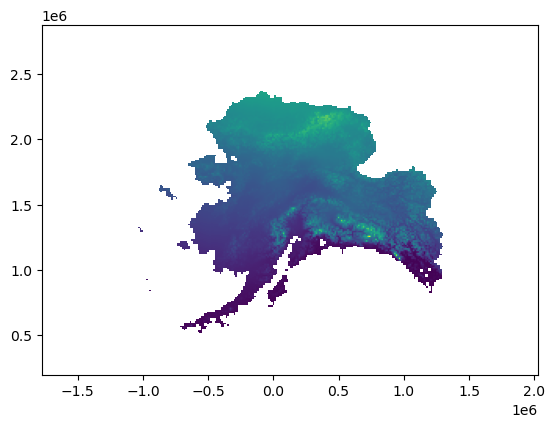

BoundingBox(left=-1776000.0, bottom=192000.0, right=2028000.0, top=2880000.0)


In [10]:
with rio.open("reprojected_afi_1981.tif") as src:
    show(src)
    print(src.bounds)

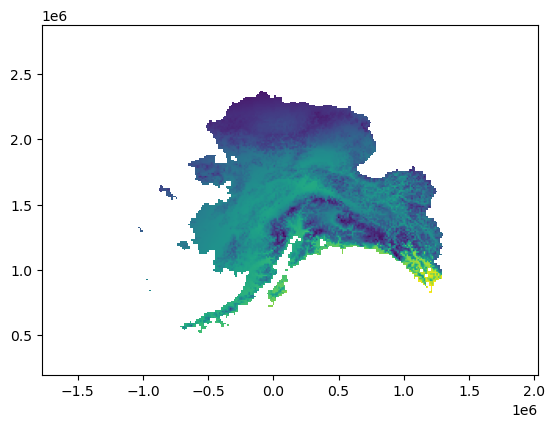

BoundingBox(left=-1776000.0, bottom=192000.0, right=2028000.0, top=2880000.0)


In [11]:
with rio.open("reprojected_ati_1981.tif") as src:
    show(src)
    print(src.bounds)

In [12]:
def get_latlons_from_snap_api():
    response = requests.get("https://earthmaps.io/places/communities")
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code {response.status_code}")
        return None


def fetch_lat_lon(community_lookup, community_name):
    for item in community_lookup:
        if item["name"] == community_name:
            return item["latitude"], item["longitude"]
    return None


communities = get_latlons_from_snap_api()

test_lat_lons = [fetch_lat_lon(communities, x) for x in test_locations]
test_setup = dict()

for test_location in test_locations:
    test_setup[test_location] = dict()
    test_setup[test_location]["latlon"] = fetch_lat_lon(communities, test_location)
    lat, lon = test_setup[test_location]["latlon"]
    
    transformer = Transformer.from_crs("EPSG:4326",  "EPSG:3338")
    x, y = transformer.transform(lat, lon)
    test_setup[test_location]["epsg3338"] = (x, y)
    
    for year in [x for x in range(wrcc_historical_start, wrcc_historical_end + 1)]:
        test_setup[test_location][year] = dict()

In [13]:
for place in test_setup:
    coords = test_setup[place]["epsg3338"]
    for year in test_setup[place].keys():
        try:
            with rio.open(f"reprojected_afi_{year}.tif") as src:
                test_setup[place][year]["AFI"] = [int(x) for x in src.sample([coords])][0]
            with rio.open(f"reprojected_ati_{year}.tif") as src:
                test_setup[place][year]["ATI"] = [int(x) for x in src.sample([coords])][0]
        except:
            pass

In [14]:
df = pd.DataFrame.from_dict(test_setup)
df = df.drop(['latlon', 'epsg3338'])
for k in df.columns:
    df[k + ' AFI'] = df[k].apply(lambda x: x['AFI'])
    df[k + ' ATI'] = df[k].apply(lambda x: x['ATI'])

for x in test_locations:
    del df[x]
df

,Utqiaġvik AFI,Utqiaġvik ATI,Fairbanks AFI,Fairbanks ATI,Kotzebue AFI,Kotzebue ATI,Anchorage AFI,Anchorage ATI,Bethel AFI,Bethel ATI
1981,7919,504,3317,3354,4647,1836,1240,3599,2125,2830
1982,8757,546,5519,3364,5370,2003,2510,3187,2943,2481
1983,8958,407,4999,3381,5124,1905,1674,3492,2471,2721
1984,10045,720,5190,3336,6733,1868,1810,3710,3364,2459
1985,8732,621,4588,3202,5719,1976,1890,3237,2767,2352
1986,8985,880,4689,3377,5688,2008,1407,3538,2676,2656
1987,8984,587,4080,3691,5824,2124,1367,3609,3102,2773
1988,9425,547,4617,3853,5750,2155,1552,3612,3304,2957
1989,8146,1235,5388,3828,5489,2190,2475,3746,3068,2840
1990,9093,874,5809,3890,6690,2583,2803,3903,3581,3041


In [15]:
summary_df = df.describe().drop(["count", "std", "25%", "50%", "75%"]).astype(int)

In [16]:
summary_df

,Utqiaġvik AFI,Utqiaġvik ATI,Fairbanks AFI,Fairbanks ATI,Kotzebue AFI,Kotzebue ATI,Anchorage AFI,Anchorage ATI,Bethel AFI,Bethel ATI
mean,8337,769,4783,3602,5498,2246,1877,3749,3075,2906
min,6764,407,3317,3017,4283,1798,1190,3187,2044,2352
max,10045,1235,6059,4095,6958,2898,2803,4311,4799,3601


In [17]:
summary_df.to_csv("daymet_afi_ati.csv")